# Imagic Stable Diffusion

Implmentation of [_Imagic: Text-Based Real Image Editing with Diffusion Models_](https://arxiv.org/abs/2210.09276) using Stable Diffusion

![](../assets/Imagic.jpeg)

This implmentation requires a GPU with ~30GB of VRAM, I'd recommend an A100 from [Lambda GPU Cloud](https://lambdalabs.com/service/gpu-cloud) which will take a little over 5 minutes to process a single image. 

Make sure you have downloaded the appropiate checkpoint for Stable Diffusion from huggingface and set up your environment correctly. (There are instructions for both in many other Stable Diffusion repos so please Google it if you're not sure.)
Note there's plenty of room for optimisation on memory usage and training parameters (this is just a quick guess based on the paper, which doesn't have many details). So please experiment and let me know how it goes!

Written by [Justin Pinkney](www.justinpinkney.com)([@Buntworthy](https://twitter.com/Buntworthy)) @ [Lambda Labs](https://lambdalabs.com/).

In [1]:
from omegaconf import OmegaConf
import torch
from PIL import Image
from torchvision import transforms
import os
from tqdm import tqdm
from einops import rearrange
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from ldm.models.diffusion.ddim import DDIMSampler
from ldm.util import instantiate_from_config

In [2]:
%cd ..

/home/jpinkney/code/stable-diffusion


In [3]:
def load_model_from_config(config, ckpt, device="cpu", verbose=False):
    """Loads a model from config and a ckpt
    if config is a path will use omegaconf to load
    """
    if isinstance(config, (str, Path)):
        config = OmegaConf.load(config)

    pl_sd = torch.load(ckpt, map_location="cpu")
    global_step = pl_sd["global_step"]
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.to(device)
    model.eval()
    model.cond_stage_model.device = device
    return model

@torch.no_grad()
def sample_model(model, sampler, c, h, w, ddim_steps, scale, ddim_eta, start_code=None, n_samples=1):
    """Sample the model"""
    uc = None
    if scale != 1.0:
        uc = model.get_learned_conditioning(n_samples * [""])

    shape = [4, h // 8, w // 8]
    samples_ddim, _ = sampler.sample(S=ddim_steps,
                                     conditioning=c,
                                     batch_size=n_samples,
                                     shape=shape,
                                     verbose=False,
                                     start_code=start_code,
                                     unconditional_guidance_scale=scale,
                                     unconditional_conditioning=uc,
                                     eta=ddim_eta,
                                    )
    return samples_ddim

def load_img(path, target_size=512):
    """Load an image, resize and output -1..1"""
    image = Image.open(path).convert("RGB")
    
    
    tform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.CenterCrop(target_size),
            transforms.ToTensor(),
        ])
    image = tform(image)
    return 2.*image - 1.

def decode_to_im(samples, n_samples=1, nrow=1):
    """Decode a latent and return PIL image"""
    samples = model.decode_first_stage(samples)
    ims = torch.clamp((samples + 1.0) / 2.0, min=0.0, max=1.0)
    x_sample = 255. * rearrange(ims.cpu().numpy(), '(n1 n2) c h w -> (n1 h) (n2 w) c', n1=n_samples//nrow, n2=nrow)
    return Image.fromarray(x_sample.astype(np.uint8))
    
    

## Setup

Load the model and encode an input image using the VAE encoder. Set the base prompt to what you want your image to contain.

In [ ]:
# Paths and prompt
device = "cuda:0"
config="configs/stable-diffusion/v1-inference.yaml"
ckpt = "models/ldm/stable-diffusion-v1/sd-v1-4-full-ema.ckpt"
input_image = "im-examples/Official_portrait_of_Barack_Obama.jpg"
prompt = "A photo of Barack Obama smiling with a big grin"

# Generation parameters
scale=3
h=512
w=512
ddim_steps=45
ddim_eta=0.0
torch.manual_seed(0)

model = load_model_from_config(config, ckpt, device)
sampler = DDIMSampler(model)

init_image = load_img(input_image).to(device).unsqueeze(0)
init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))
decode_to_im(init_latent)

orig_emb = model.get_learned_conditioning([prompt])
emb = orig_emb.clone()

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 45 timesteps


DDIM Sampler: 100%|████████████████████████████| 45/45 [00:04<00:00,  9.31it/s]


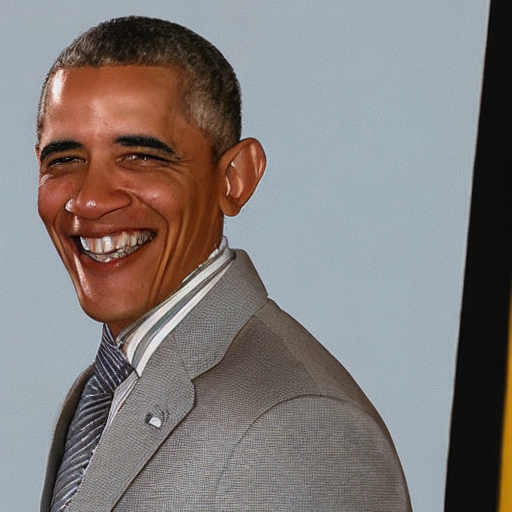

In [5]:
# Sample the model with a fixed code to see what it looks like
quick_sample = lambda x, s, code: decode_to_im(sample_model(model, sampler, x, h, w, ddim_steps, s, ddim_eta, start_code=code))
start_code = torch.randn_like(init_latent)
quick_sample(emb, scale, start_code)

## Step 1 - Optimise the embedding

Optimise the embedding just a little to move it to a place that will better reconstruct our original photo (it won't reconstruct it yet though). And let us interpolate toward the original position to generate our desired edit.

In [6]:
emb.requires_grad = True
lr = 0.001
it = 500
opt = torch.optim.Adam([emb], lr=lr)
criteria = torch.nn.MSELoss()
history = []

pbar = tqdm(range(it))
for i in pbar:
    opt.zero_grad()
    
    noise = torch.randn_like(init_latent)
    t_enc = torch.randint(1000, (1,), device=device)
    z = model.q_sample(init_latent, t_enc, noise=noise)
    
    pred_noise = model.apply_model(z, t_enc, emb)
    
    loss = criteria(pred_noise, noise)
    loss.backward()
    pbar.set_postfix({"loss": loss.item()})
    history.append(loss.item())
    opt.step()


100%|████████████████████████████| 500/500 [02:14<00:00,  3.72it/s, loss=0.374]


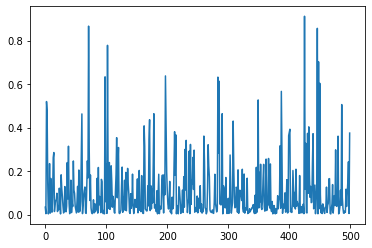

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 45 timesteps


DDIM Sampler: 100%|████████████████████████████| 45/45 [00:04<00:00,  9.09it/s]


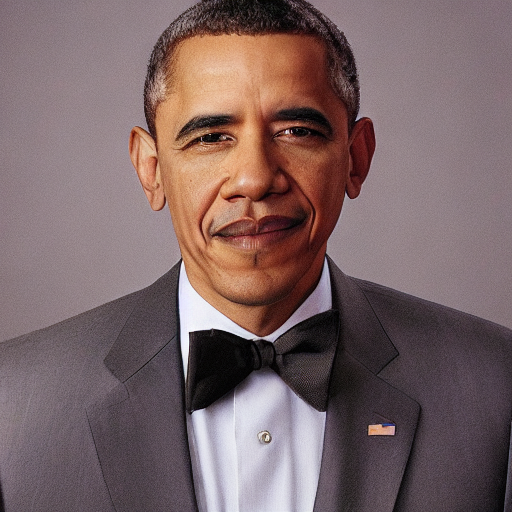

In [7]:
plt.plot(history)
plt.show()
quick_sample(emb, scale, start_code)

## Step 2 - Fine tune the model

Fine tune the whole diffusion model so that we can accurately recreate our input image.

In [8]:

emb.requires_grad = False
model.train()

lr = 1e-6
it = 1000
opt = torch.optim.Adam(model.model.parameters(), lr=lr)
criteria = torch.nn.MSELoss()
history = []

pbar = tqdm(range(it))
for i in pbar:
    opt.zero_grad()
    
    noise = torch.randn_like(init_latent)
    t_enc = torch.randint(model.num_timesteps, (1,), device=device)
    z = model.q_sample(init_latent, t_enc, noise=noise)
    
    pred_noise = model.apply_model(z, t_enc, emb)
    
    loss = criteria(pred_noise, noise)
    loss.backward()
    pbar.set_postfix({"loss": loss.item()})
    history.append(loss.item())
    opt.step()


100%|█████████████████████████| 1000/1000 [05:34<00:00,  2.99it/s, loss=0.0138]


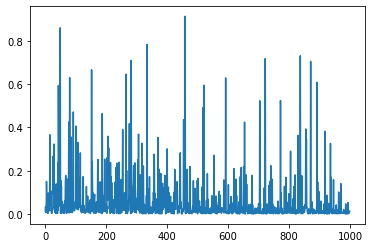

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 45 timesteps


DDIM Sampler: 100%|████████████████████████████| 45/45 [00:04<00:00,  9.09it/s]


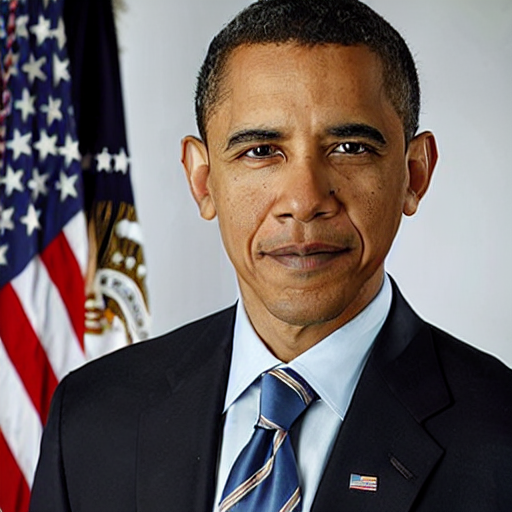

In [9]:
model.eval()
plt.plot(history)
plt.show()
quick_sample(emb, scale, start_code)
# Should look like the original image

## Step 3 - Generate images

Now we interpolate our learned embedding with the new embedding, and use as the condition for our fine tuned model to produce an edited image.

~~For some reason the range of interpolation values in the paper doesn't give editing results as we want. We have to go *beyond 1* which seems a little odd...~~

The issue with the previous version was not training the embedding long enough. With the modified parameters we get behaviour more like the original paper.

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 45 timesteps


DDIM Sampler: 100%|████████████████████████████| 45/45 [00:04<00:00,  9.23it/s]


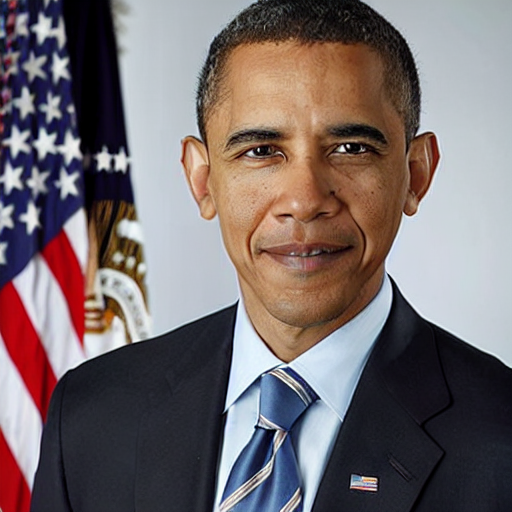

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 45 timesteps


DDIM Sampler: 100%|████████████████████████████| 45/45 [00:04<00:00,  9.19it/s]


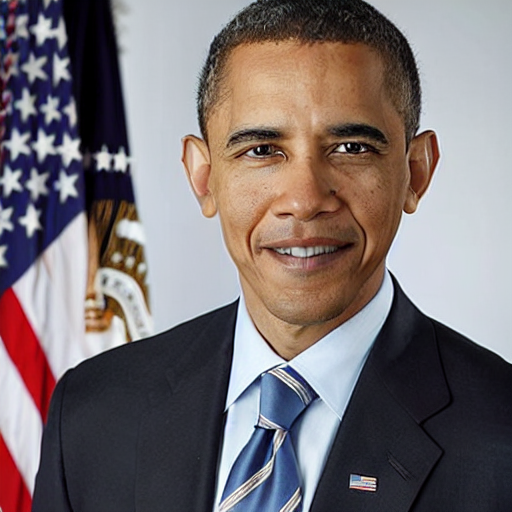

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 45 timesteps


DDIM Sampler: 100%|████████████████████████████| 45/45 [00:04<00:00,  9.18it/s]


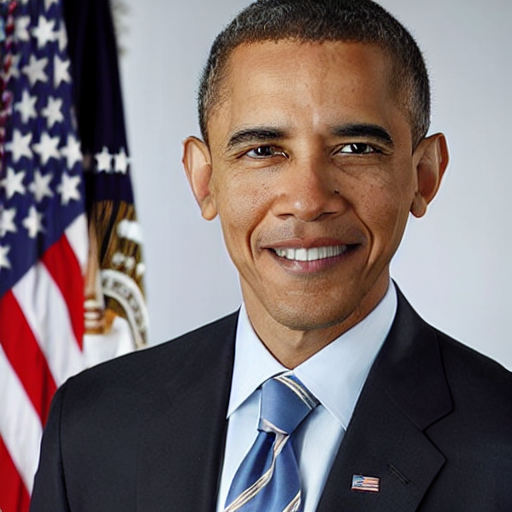

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 45 timesteps


DDIM Sampler: 100%|████████████████████████████| 45/45 [00:04<00:00,  9.17it/s]


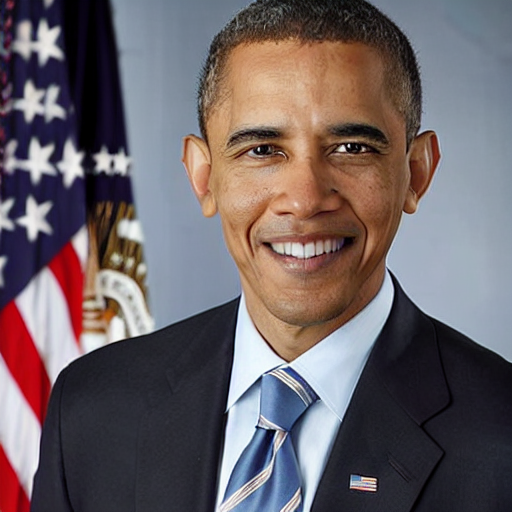

In [12]:
# Interpolate the embedding
for alpha in (0.8, 0.9, 1, 1.1):
    new_emb = alpha*orig_emb + (1-alpha)*emb
    display(quick_sample(new_emb, scale, start_code))